In [ ]:
s3_location1 = ''
s3_location2 = ''
s3_location3 = ''

# Illustrating Behaviours and Data Properties for the supplement
# Figures S1, S2, S3
Developed by Siobhan Powell, 2022.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import boto3
import scipy.cluster.hierarchy as shc
import pickle

In [2]:
driver_subset_total = pd.read_csv(s3_location1, index_col=0)
driver_subset_labels = pd.read_csv(s3_location2, index_col=0)
driver_subset = driver_subset_total[driver_subset_total['Unique Driver ID'].isin(driver_subset_labels['Unique Driver ID'].values)].copy(deep=True).reset_index(drop=True)

In [148]:
len(driver_subset_labels.loc[(driver_subset_labels['A_flag_home']=='0')])

26110

# About the Data Set

In [7]:
df_sessions = pd.read_csv(s3_location3, index_col=0)


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [75]:
df_sessions = df_sessions[df_sessions['Driver ID'].isin(driver_subset['Unique Driver ID'].values)]
df_sessions = df_sessions.reset_index(drop=True)

In [79]:
df_drivers_grouped = df_sessions.groupby('Driver ID').agg('mean')
max_drivers = df_sessions.groupby('Driver ID').agg('max')
inds = df_drivers_grouped[df_drivers_grouped['Battery Capacity'] != df_drivers_grouped['Battery Capacity']].index
df_drivers_grouped.loc[inds, 'Battery Capacity'] = max_drivers.loc[inds, 'Energy (kWh)']

In [80]:
plotting_df_sessions = df_sessions.loc[:, ['County', 'POI Category', 'start_weekday']].copy(deep=True)
plotting_df_sessions['County_plot'] = plotting_df_sessions['County']
plotting_df_sessions.loc[plotting_df_sessions[plotting_df_sessions['County'].isin(['Napa County', 'Solano County', 'Sonoma County'])].index, 'County_plot'] = 'Other'

plotting_df_sessions['Weekday_name'] = 0
names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for i in range(7):
    inds = plotting_df_sessions[plotting_df_sessions['start_weekday']==i].index
    plotting_df_sessions.loc[inds, 'Weekday_name'] = names[i]
    
plotting_df_sessions['POI Category plot'] = 'Other'
inds = plotting_df_sessions[plotting_df_sessions['POI Category']=='Workplace'].index
plotting_df_sessions.loc[inds, 'POI Category plot'] = 'Workplace'
inds = plotting_df_sessions[plotting_df_sessions['POI Category']=='Single family residential'].index
plotting_df_sessions.loc[inds, 'POI Category plot'] = 'Single family home'
inds = plotting_df_sessions[plotting_df_sessions['POI Category']=='Multifamily Home Service'].index
plotting_df_sessions.loc[inds, 'POI Category plot'] = 'Multi-unit dwelling'

In [81]:
plotting_df_drivers = df_drivers_grouped.loc[:, ['Battery Capacity', 'Vehicle Model Year']].copy(deep=True)
plotting_df_drivers['Vehicle Make'] = df_sessions.groupby('Driver ID')['Vehicle Make'].agg(pd.Series.mode)

In [88]:
plotting_df_drivers['Battery Capacity plot'] = 'Unknown'
for i in range(4):
    inds = plotting_df_drivers.loc[(plotting_df_drivers['Battery Capacity']>(i*25))&(plotting_df_drivers['Battery Capacity']<=((i+1)*25))].index
    plotting_df_drivers.loc[inds, 'Battery Capacity plot'] = str(i*25) + ' to '+str((i+1)*25) + ' kWh'

In [89]:
inds = plotting_df_drivers[plotting_df_drivers['Vehicle Model Year']==plotting_df_drivers['Vehicle Model Year']].index
plotting_df_drivers.loc[inds, 'Vehicle Model Year'] = plotting_df_drivers.loc[inds, 'Vehicle Model Year'].astype(int)
inds = plotting_df_drivers[plotting_df_drivers['Vehicle Model Year']!=plotting_df_drivers['Vehicle Model Year']].index
plotting_df_drivers.loc[inds, 'Vehicle Model Year'] = 'Unknown'

In [93]:
plotting_df_drivers['Vehicle Make'].astype('str').value_counts()[0:20]

Tesla            12658
Chevrolet         4581
Nissan            4224
Volkswagen        1899
BMW               1468
Honda              990
Fiat               696
Ford               377
Kia                235
Toyota             124
Hyundai            104
Mercedes-Benz      101
Jaguar              96
Audi                68
Smart               51
Volvo               26
Mitsubishi          11
CODA                 5
Chrysler             4
Think                3
Name: Vehicle Make, dtype: int64

In [126]:
plotting_df_drivers['Vehicle Make plot'] = 'Other'
for vehmake in ['Tesla', 'Chevrolet', 'Nissan', 'Volkswagen', 'BMW', 'Honda', 'Fiat']:
    inds = plotting_df_drivers[(plotting_df_drivers['Vehicle Make'].astype(str)==vehmake)].index
    plotting_df_drivers.loc[inds, 'Vehicle Make plot'] = vehmake

In [98]:
# for plotting:
pie_charts = {'County plot':None, 'POI Category plot':None, 'Weekday_name':None, 'Battery Capacity plot':None, 'Vehicle Make':None, 'Vehicle Model Year':None}

In [127]:
pie_charts['County plot'] = pd.DataFrame({'Values':plotting_df_sessions['County_plot'].value_counts().values,
                                          'Labels':plotting_df_sessions['County_plot'].value_counts().keys()})
pie_charts['POI Category plot'] = pd.DataFrame({'Values':plotting_df_sessions['POI Category plot'].value_counts().values,
                                          'Labels':plotting_df_sessions['POI Category plot'].value_counts().keys()})
pie_charts['Vehicle Make'] = pd.DataFrame({'Values':plotting_df_drivers['Vehicle Make plot'].value_counts().values,
                                          'Labels':plotting_df_drivers['Vehicle Make plot'].value_counts().keys()})

In [100]:
cts = plotting_df_sessions['Weekday_name'].value_counts()
pie_charts['Weekday_name'] = pd.DataFrame({'Values':np.zeros((len(cts), )), 
                                           'Labels':['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']})
for i, val in cts.items():
    idx = pie_charts['Weekday_name'].loc[pie_charts['Weekday_name']['Labels']==i].index
    pie_charts['Weekday_name'].loc[idx, 'Values'] = val

In [103]:
cts = plotting_df_drivers['Battery Capacity plot'].value_counts()
pie_charts['Battery Capacity plot'] = pd.DataFrame({'Values':np.zeros((len(cts), )), 
                                           'Labels':['0 to 25 kWh', '25 to 50 kWh', '50 to 75 kWh', '75 to 100 kWh']})
for i, val in cts.items():
    idx = pie_charts['Battery Capacity plot'].loc[pie_charts['Battery Capacity plot']['Labels']==i].index
    pie_charts['Battery Capacity plot'].loc[idx, 'Values'] = val

In [104]:
cts

50 to 75 kWh     13445
0 to 25 kWh       6516
25 to 50 kWh      6277
75 to 100 kWh     1489
Name: Battery Capacity plot, dtype: int64

In [105]:
cts['0 to 25 kWh'] + cts['25 to 50 kWh']

12793

In [110]:
inds = plotting_df_drivers[plotting_df_drivers['Vehicle Model Year'].isin([2008, 2009, 2010, 2011, 2012])].index
plotting_df_drivers.loc[inds, 'Vehicle Model Year'] = '2012 or earlier'

In [119]:
inds = plotting_df_drivers[plotting_df_drivers['Vehicle Model Year'].isin(['2012 or earlier', 2020, 'Unknown'])].index
plotting_df_drivers.loc[inds, 'Vehicle Model Year'] = 'Other or Unknown'

In [120]:
cts = plotting_df_drivers['Vehicle Model Year'].value_counts()

In [121]:
cts

2018.0              11000
2017.0               5454
2016.0               3241
2019.0               3027
2015.0               2138
2014.0               1133
2013.0                870
Other or Unknown      864
Name: Vehicle Model Year, dtype: int64

In [123]:
pie_charts['Vehicle Model Year'] = pd.DataFrame({'Values':np.zeros((len(cts), )), 
                                           'Labels':[2019, 2018, 2017, 2016, 2015, 2014, 2013, 'Other or Unknown']})
for i, val in cts.items():
    idx = pie_charts['Vehicle Model Year'].loc[pie_charts['Vehicle Model Year']['Labels']==i].index
    pie_charts['Vehicle Model Year'].loc[idx, 'Values'] = val

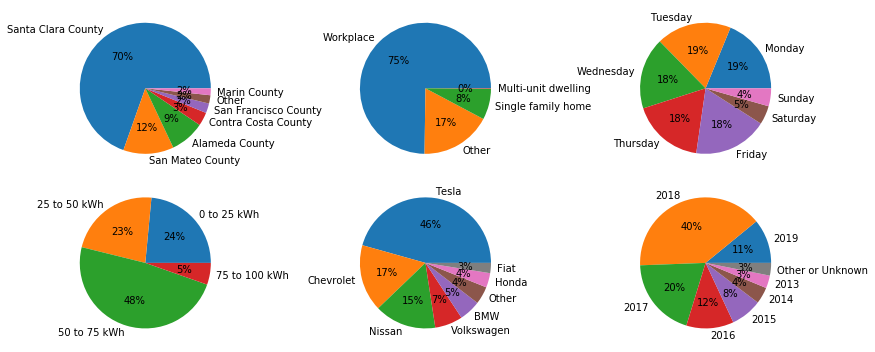

In [133]:
fig, axes = plt.subplots(2, 3, figsize=(12, 5))
axes[0, 0].pie(pie_charts['County plot']['Values'], labels=pie_charts['County plot']['Labels'], autopct='%1.0f%%')
axes[0, 1].pie(pie_charts['POI Category plot']['Values'], labels=pie_charts['POI Category plot']['Labels'], autopct='%1.0f%%')
axes[0, 2].pie(pie_charts['Weekday_name']['Values'], labels=pie_charts['Weekday_name']['Labels'], autopct='%1.0f%%')
axes[1, 0].pie(pie_charts['Battery Capacity plot']['Values'], labels=pie_charts['Battery Capacity plot']['Labels'], autopct='%1.0f%%')
axes[1, 1].pie(pie_charts['Vehicle Make']['Values'], labels=pie_charts['Vehicle Make']['Labels'], autopct='%1.0f%%')
axes[1, 2].pie(pie_charts['Vehicle Model Year']['Values'], labels=pie_charts['Vehicle Model Year']['Labels'], autopct='%1.0f%%')
plt.tight_layout()
plt.savefig('../Plotting/fig_piecharts_about_data.pdf', bbox_inches='tight')
plt.savefig('../Plotting/fig_piecharts_about_data.png', bbox_inches='tight')
plt.show()



In [149]:
len(df_sessions[df_sessions['POI Category']=='Multifamily Home Service'])

3592

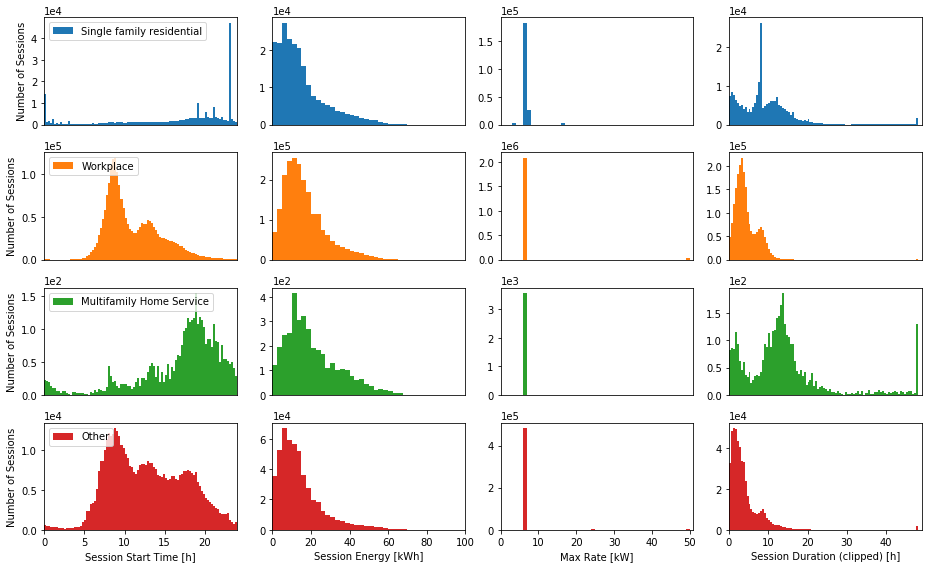

In [144]:
fig, axes = plt.subplots(4, 4, figsize=(13, 8))
df_sessions['category_label'] = 'Other'
for cat in ['Single family residential', 'Workplace', 'Multifamily Home Service']:
    inds = df_sessions.loc[df_sessions['POI Category']==cat].index
    df_sessions.loc[inds, 'category_label'] = cat
    
colors = ['C0', 'C1', 'C2', 'C3']
for i, cat in enumerate(['Single family residential', 'Workplace', 'Multifamily Home Service', 'Other']):
    axes[i, 0].hist((1/3600)*df_sessions[df_sessions['category_label']==cat]['start_seconds'], bins=np.arange(0, 24.05, 0.25), color=colors[i], label=cat)
    axes[i, 0].legend(fontsize=10, loc='upper left')
    axes[i, 1].hist(df_sessions[df_sessions['category_label']==cat]['Energy (kWh)'], bins=np.arange(0, 100, 2.5), color=colors[i])
    axes[i, 2].hist(df_sessions[df_sessions['category_label']==cat]['Max Power'], bins=np.arange(0, 51, 1), color=colors[i])
    axes[i, 3].hist(np.clip((1/3600)*df_sessions[df_sessions['category_label']==cat]['Session Time (secs)'].values, 0, 48), bins=np.arange(0, 48.05, 0.5), color=colors[i])
    
    for j in range(4):
        axes[i, j].ticklabel_format(style='sci', axis='y', scilimits=(0,0), useOffset=False)
    
    axes[i, 0].set_xlim([0, 24])
    axes[i, 1].set_xlim([0, 100])
    axes[i, 2].set_xlim([0, 51])
    axes[i, 3].set_xlim([0, 49])
    axes[i, 0].set_ylabel('Number of Sessions', fontsize=10)
    if i < 3:
        for j in range(4):
            axes[i, j].set_xticks([])
    else:
        axes[i, 0].set_xlabel('Session Start Time [h]', fontsize=10)
        axes[i, 1].set_xlabel('Session Energy [kWh]', fontsize=10)
        axes[i, 2].set_xlabel('Max Rate [kW]', fontsize=10)
        axes[i, 3].set_xlabel('Session Duration (clipped) [h]', fontsize=10)

plt.tight_layout()
plt.savefig('../Plotting/fig_histograms_data.png', bbox_inches='tight')
plt.savefig('../Plotting/fig_histograms_data.pdf', bbox_inches='tight')
plt.show()
    

# About the Drivers

In [11]:
for i in range(136):
    drivers = driver_subset_labels[driver_subset_labels['Agglom Cluster Number']==i]['Unique Driver ID'].values
    inds = driver_subset.loc[driver_subset['Unique Driver ID'].isin(drivers)].index
    driver_subset.loc[inds, 'Agglom Cluster Number'] = i

# same energy: large battery vs small battery

In [24]:
test = driver_subset.loc[(driver_subset['Total Energy'] > 2000)&(driver_subset['Total Energy'] <= 3000)]

In [39]:
test2 = pd.DataFrame({'Agglom Cluster Number':list(test['Agglom Cluster Number'].value_counts().keys())})
for i in test2.index:
    test2.loc[i, 'Mean Battery Capacity'] = test[test['Agglom Cluster Number']==test2.loc[i, 'Agglom Cluster Number']]['Battery Capacity'].mean()
    test2.loc[i, 'Mean Number of Home Sessions'] = (test[test['Agglom Cluster Number']==test2.loc[i, 'Agglom Cluster Number']]['Num Single Family Residential Sessions'].mean()) + (test[test['Agglom Cluster Number']==test2.loc[i, 'Agglom Cluster Number']]['Num MUD Sessions'].mean())
    test2.loc[i, 'Mean Number of Sessions'] = (test[test['Agglom Cluster Number']==test2.loc[i, 'Agglom Cluster Number']]['Num Sessions'].mean())
    test2.loc[i, 'Mean Number of Non-Home Sessions'] = (test[test['Agglom Cluster Number']==test2.loc[i, 'Agglom Cluster Number']]['Num Other Slow Sessions'].mean()) + (test[test['Agglom Cluster Number']==test2.loc[i, 'Agglom Cluster Number']]['Num Other Fast Sessions'].mean()) + (test[test['Agglom Cluster Number']==test2.loc[i, 'Agglom Cluster Number']]['Num Workplace Sessions'].mean())
    test2.loc[i, 'Number of Drivers'] = len(test[test['Agglom Cluster Number']==test2.loc[i, 'Agglom Cluster Number']])

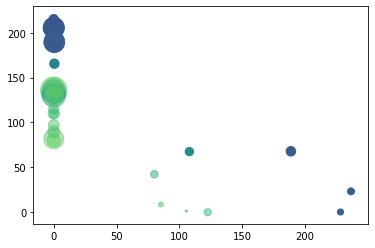

In [38]:
inds1 = test2[test2['Mean Battery Capacity']>50].index
plt.scatter(test2.loc[inds1, 'Mean Number of Home Sessions'].values, test2.loc[inds1, 'Mean Number of Non-Home Sessions'].values, c=test2.loc[inds1, 'Mean Battery Capacity'].values, vmin=0, vmax=100, s=test2.loc[inds1, 'Number of Drivers'], alpha=0.5)
inds2 = test2[test2['Mean Battery Capacity']<=50].index
plt.scatter(test2.loc[inds2, 'Mean Number of Home Sessions'].values, test2.loc[inds2, 'Mean Number of Non-Home Sessions'].values, c=test2.loc[inds2, 'Mean Battery Capacity'].values, vmin=0, vmax=100, s=test2.loc[inds2, 'Number of Drivers'])

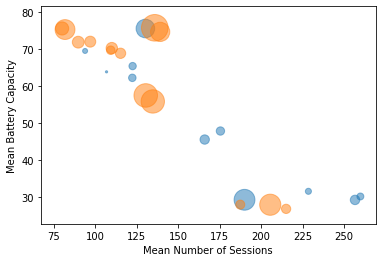

In [42]:
inds1 = test2.loc[(test2['Mean Number of Home Sessions']>0)].index
plt.scatter(test2.loc[inds1, 'Mean Number of Sessions'].values, test2.loc[inds1, 'Mean Battery Capacity'].values, s=test2.loc[inds1, 'Number of Drivers'], alpha=0.5)
inds2 = test2.loc[(test2['Mean Number of Home Sessions']==0)].index
plt.scatter(test2.loc[inds2, 'Mean Number of Sessions'].values, test2.loc[inds2, 'Mean Battery Capacity'].values, s=test2.loc[inds2, 'Number of Drivers'], alpha=0.5)
plt.xlabel('Mean Number of Sessions')
plt.ylabel('Mean Battery Capacity')
plt.show()

In [ ]:
inds1 = test2.loc[(test2['Mean Number of Home Sessions']>0)].index
plt.scatter(test2.loc[inds1, 'Mean Number of Sessions'].values, test2.loc[inds1, 'Mean Battery Capacity'].values, s=test2.loc[inds1, 'Number of Drivers'], alpha=0.5)
inds2 = test2.loc[(test2['Mean Number of Home Sessions']==0)].index
plt.scatter(test2.loc[inds2, 'Mean Number of Sessions'].values, test2.loc[inds2, 'Mean Battery Capacity'].values, s=test2.loc[inds2, 'Number of Drivers'], alpha=0.5)


In [69]:
tmp = driver_subset.loc[(driver_subset['Num Single Family Residential Sessions']==0)&(driver_subset['Num MUD Sessions']==0)&(driver_subset['Num Workplace Sessions']==0)]
tmp2 = tmp.groupby('Agglom Cluster Number').agg('mean')
# tmp3 = tmp.groupby('Agglom Cluster Number').agg('sum')

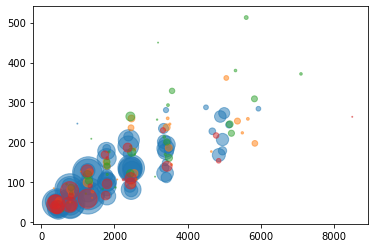

In [127]:
tmp = driver_subset.loc[(driver_subset['Num Single Family Residential Sessions']==0)&(driver_subset['Num MUD Sessions']==0)&(driver_subset['Num Workplace Sessions']>0)]
tmp2 = tmp.groupby('Agglom Cluster Number').agg('mean')
for i in tmp2.index:
    tmp2.loc[i, 'Num Drivers'] = tmp['Agglom Cluster Number'].value_counts()[i]
plt.scatter(tmp2['Total Energy'].values, tmp2['Num Sessions'].values, s=tmp2['Num Drivers'], c='C0', alpha=0.5)
tmp = driver_subset.loc[(driver_subset.loc[:, ['Num Single Family Residential Sessions','Num MUD Sessions']].sum(axis=1)>0)&(driver_subset['Num Workplace Sessions']==0)]
tmp2 = tmp.groupby('Agglom Cluster Number').agg('mean')
for i in tmp2.index:
    tmp2.loc[i, 'Num Drivers'] = tmp['Agglom Cluster Number'].value_counts()[i]
plt.scatter(tmp2['Total Energy'].values, tmp2['Num Sessions'].values, s=tmp2['Num Drivers'], c='C1', alpha=0.5)
tmp = driver_subset.loc[(driver_subset.loc[:, ['Num Single Family Residential Sessions','Num MUD Sessions']].sum(axis=1)>0)&(driver_subset['Num Workplace Sessions']>0)]
tmp2 = tmp.groupby('Agglom Cluster Number').agg('mean')
for i in tmp2.index:
    tmp2.loc[i, 'Num Drivers'] = tmp['Agglom Cluster Number'].value_counts()[i]
plt.scatter(tmp2['Total Energy'].values, tmp2['Num Sessions'].values, s=tmp2['Num Drivers'], c='C2', alpha=0.5)
tmp = driver_subset.loc[(driver_subset['Num Single Family Residential Sessions']==0)&(driver_subset['Num MUD Sessions']==0)&(driver_subset['Num Workplace Sessions']==0)]
tmp2 = tmp.groupby('Agglom Cluster Number').agg('mean')
for i in tmp2.index:
    tmp2.loc[i, 'Num Drivers'] = tmp['Agglom Cluster Number'].value_counts()[i]
plt.scatter(tmp2['Total Energy'].values, tmp2['Num Sessions'].values, s=tmp2['Num Drivers'], c='C3', alpha=0.5)
# plt.colorbar()
plt.show()

In [166]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

### Drivers with home vs workplace vs other charge more/less on weekdays vs weekends?
### Drivers with smaller batteries charge more often?

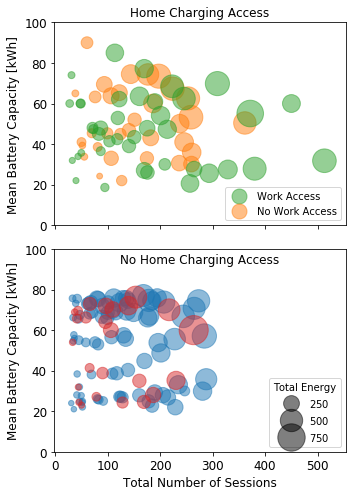

In [175]:
fig, axes = plt.subplots(2, 1, figsize=(5, 7), sharex=True, sharey=True)

axes[0].set_title('Home Charging Access')
tmp = driver_subset.loc[(driver_subset.loc[:, ['Num Single Family Residential Sessions','Num MUD Sessions']].sum(axis=1)>0)&(driver_subset['Num Workplace Sessions']==0)]
tmp2 = tmp.groupby('Agglom Cluster Number').agg('mean')
for i in tmp2.index:
    tmp2.loc[i, 'Num Drivers'] = tmp['Agglom Cluster Number'].value_counts()[i]
axes[0].scatter(tmp2['Num Sessions'], tmp2['Battery Capacity'], s=(1/10)*tmp2['Total Energy'], alpha=0.5, color='C1', label='No Workplace Access')
tmp = driver_subset.loc[(driver_subset.loc[:, ['Num Single Family Residential Sessions','Num MUD Sessions']].sum(axis=1)>0)&(driver_subset['Num Workplace Sessions']>0)]
tmp2 = tmp.groupby('Agglom Cluster Number').agg('mean')
for i in tmp2.index:
    tmp2.loc[i, 'Num Drivers'] = tmp['Agglom Cluster Number'].value_counts()[i]
axes[0].scatter(tmp2['Num Sessions'], tmp2['Battery Capacity'], s=(1/10)*tmp2['Total Energy'], alpha=0.5, label='Workplace Access', color='C2')
axes[0].set_ylim([0, 100])
# plt.xticks([])
axes[0].set_yticks(np.arange(0, 101, 20)); axes[0].set_yticklabels([0,20,40,60,80,100],fontsize=12)
axes[0].set_ylabel('Mean Battery Capacity [kWh]', fontsize=12)
# plt.subplot(212)
# plt.xlim([0, 550])
axes[1].set_title('No Home Charging Access', y=0.9)
tmp = driver_subset.loc[(driver_subset['Num Single Family Residential Sessions']==0)&(driver_subset['Num MUD Sessions']==0)&(driver_subset['Num Workplace Sessions']>0)]
tmp2 = tmp.groupby('Agglom Cluster Number').agg('mean')
for i in tmp2.index:
    tmp2.loc[i, 'Num Drivers'] = tmp['Agglom Cluster Number'].value_counts()[i]
axes[1].scatter(tmp2['Num Sessions'], tmp2['Battery Capacity'], s=(1/10)*tmp2['Total Energy'], alpha=0.5, color='C0', label='Workplace Access')
tmp = driver_subset.loc[(driver_subset['Num Single Family Residential Sessions']==0)&(driver_subset['Num MUD Sessions']==0)&(driver_subset['Num Workplace Sessions']==0)]
tmp2 = tmp.groupby('Agglom Cluster Number').agg('mean')
for i in tmp2.index:
    tmp2.loc[i, 'Num Drivers'] = tmp['Agglom Cluster Number'].value_counts()[i]
sc = axes[1].scatter(tmp2['Num Sessions'], tmp2['Battery Capacity'], s=(1/10)*tmp2['Total Energy'], alpha=0.5, label='No Workplace Access', color='C3')
# plt.ylim([0, 100])
axes[1].set_xlabel('Total Number of Sessions', fontsize=12)
axes[1].set_ylabel('Mean Battery Capacity [kWh]', fontsize=12)
axes[1].set_yticks(np.arange(0, 101, 20)); axes[1].set_yticklabels([0,20,40,60,80,100],fontsize=12)
axes[1].set_xticks([0, 100, 200, 300, 400, 500]); axes[1].set_xticklabels([0, 100, 200, 300, 400, 500], fontsize=12)
# sc = plt.scatter(x, y, s=a2, alpha=0.5)
axes[1].legend(*sc.legend_elements("sizes", num=4), title='Total Energy', loc='lower right')

legend_elements = [Line2D([0], [0], lw=0, marker='o', color='C2', label='Scatter', markerfacecolor='C2', markersize=15, alpha=0.5), 
                   Line2D([0], [0], lw=0, marker='o', color='C1', label='Scatter', markerfacecolor='C1', markersize=15, alpha=0.5)]
axes[0].legend(handles=legend_elements, loc='lower right', labels=['Work Access', 'No Work Access'])

plt.tight_layout()
plt.savefig('fig_access_batt_num_part2.pdf', bbox_inches='tight')
plt.show()

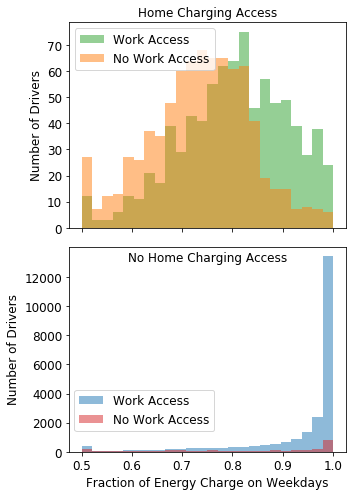

In [195]:
fig, axes = plt.subplots(2, 1, figsize=(5, 7), sharex=True, sharey=False)

axes[0].set_title('Home Charging Access')

tmp3 = driver_subset.loc[(driver_subset.loc[:, ['Num Single Family Residential Sessions', 'Num MUD Sessions']].sum(axis=1)>0)&(driver_subset['Num Workplace Sessions']>0)]
axes[0].hist(np.clip(tmp3['Total Energy - weekday'].values / tmp3['Total Energy'].values, 0.5, 1), alpha=0.5, density=False, bins=np.linspace(0.5, 1, 25), color='C2', label='Work Access')
tmp3 = driver_subset.loc[(driver_subset.loc[:, ['Num Single Family Residential Sessions', 'Num MUD Sessions']].sum(axis=1)>0)&(driver_subset['Num Workplace Sessions']==0)]
axes[0].hist(np.clip(tmp3['Total Energy - weekday'].values / tmp3['Total Energy'].values, 0.5, 1), alpha=0.5, density=False, bins=np.linspace(0.5, 1, 25), color='C1', label='No Work Access')
axes[0].legend(loc='upper left', fontsize=12)
axes[1].set_title('No Home Charging Access', y=0.9)
tmp3 = driver_subset.loc[(driver_subset['Num Workplace Sessions']>0)&(driver_subset.loc[:, ['Num Single Family Residential Sessions', 'Num MUD Sessions']].sum(axis=1)==0)]
axes[1].hist(np.clip(tmp3['Total Energy - weekday'].values / tmp3['Total Energy'].values, 0.5, 1), alpha=0.5, density=False, bins=np.linspace(0.5, 1, 25), color='C0', label='Work Access')
tmp3 = driver_subset.loc[(driver_subset['Num Single Family Residential Sessions']==0)&(driver_subset['Num MUD Sessions']==0)&(driver_subset['Num Workplace Sessions']==0)]
axes[1].hist(np.clip(tmp3['Total Energy - weekday'].values / tmp3['Total Energy'].values, 0.5, 1), alpha=0.5, density=False, bins=np.linspace(0.5, 1, 25), color='C3', label='No Work Access')
axes[1].legend(loc=(0.02, 0.1), fontsize=12)
axes[1].set_xlabel('Fraction of Energy Charge on Weekdays', fontsize=12)
axes[1].set_xticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
axes[1].set_xticklabels([0.5, 0.6, 0.7, 0.8, 0.9, 1.0], fontsize=12)
axes[0].set_yticks([0, 10, 20, 30, 40, 50, 60, 70]); axes[0].set_yticklabels([0, 10, 20, 30, 40, 50, 60, 70], fontsize=12)
axes[1].set_yticks([0, 2000, 4000, 6000, 8000, 10000, 12000]); axes[1].set_yticklabels([0, 2000, 4000, 6000, 8000, 10000, 12000], fontsize=12)
axes[0].set_ylabel('Number of Drivers', fontsize=12)
axes[1].set_ylabel('Number of Drivers', fontsize=12)
plt.tight_layout()
plt.savefig('fig_access_weekends.pdf', bbox_inches='tight')
plt.show()

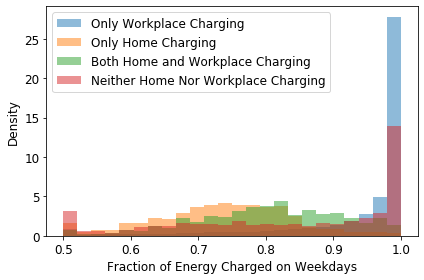

In [101]:
plt.figure()
plt.legend(labels=['Only Workplace Charging', 'Only Home Charging', 'Both Home and Workplace Charging', 'Neither Home Nor Workplace Charging'], fontsize=12)
plt.xlabel('Fraction of Energy Charged on Weekdays', fontsize=12)
plt.xticks(fontsize=12); plt.yticks(fontsize=12)
# plt.yticks([])
plt.ylabel('Density', fontsize=12)
plt.tight_layout()
plt.savefig('fig_fractiononweekdays.png', bbox_inches='tight')
plt.savefig('fig_fractiononweekdays.pdf', bbox_inches='tight')
plt.show()

# Typical day of drivers 
- With MUD charging
- With single family home charging

-> Zoom in on dendrogram

In [196]:
tmp = driver_subset.loc[(driver_subset['Total Energy']>2000)&(driver_subset['Total Energy']<=3000)]

In [200]:
mapping_dend = {'green':[80, 74, 72, 87, 78], 'red':[75, 93, 73, 92, 91, 90, 69], 'blue1':[86, 76, 70, 88, 79, 83], 'blue2':[85, 89, 84, 71, 77, 81, 82]}

In [205]:
mapping_dend # 72 green; 70 blue1, 77 blue2, 69 red

{'green': [80, 74, 72, 87, 78],
 'red': [75, 93, 73, 92, 91, 90, 69],
 'blue1': [86, 76, 70, 88, 79, 83],
 'blue2': [85, 89, 84, 71, 77, 81, 82]}

In [206]:
import os
os.chdir('../RunningModel')

In [207]:
from speech_classes import SPEECh
from speech_classes import SPEEChGeneralConfiguration
from speech_classes import LoadProfile
from speech_classes import Plotting
from speech_classes import DataSetConfigurations

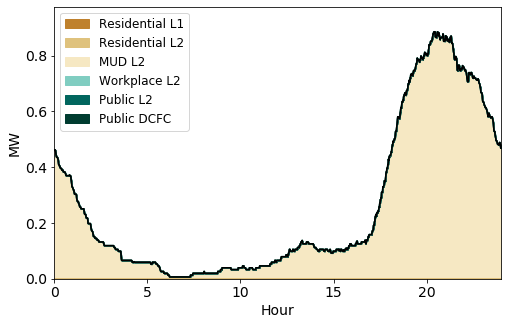

In [215]:
data = DataSetConfigurations(data_set='CP')
speech = SPEECh(data=data, penetration_level=1.0, outside_california=True, states=['OR'])
speech.pg = pd.DataFrame({'pg':(1/136)*np.ones((136, ))})
config = SPEEChGeneralConfiguration(speech, remove_timers=False)
config.change_pg(new_weights={85: 1})
# config.num_evs(tmp['Agglom Cluster Number'].value_counts()[72])  # Input number of EVs in simulation
config.num_evs(1000)
config.groups()
config.run_all(verbose=False, weekday='weekday')
plots = Plotting(speech, config)
plots.total(save_str=None)#'simple_example_plot_adjusted.png')

In [258]:
def plot_custom(ax, speech, load_segments_array, load_segments_dict, set_ylim=None, save_str=None, title=None, yax=False, legend_subset=None):
    """Plot a single day profile."""
    x = (1/60)*np.arange(0, 1440)
    mark = np.zeros(np.shape(x))
    scaling = 1 / 1000
    patterns = ['/', '///', '\\', 'x', '.', '*']
    legend_rename = {'Residential L2':'SFH L2', 'MUD L2':'MUD L2', 'Workplace L2':'Workplace L2', 'Public L2':'Public L2', 'Public DCFC':'Public DCFC'}
    unit = 'MW'
    ax.set_ylim([0, 1.5])
    ax.set_axisbelow(True)        
    ax.grid(alpha=0.7, zorder=2)
    for key, val in load_segments_dict.items():
        ax.plot(x, scaling * (mark + val), color=speech.data.colours[key])
        if legend_subset is not None:
            if key in legend_subset:
                ax.fill_between(x, scaling * mark, scaling * (mark + val), hatch=patterns[i], facecolor=speech.data.colours[key], label=legend_rename[key], edgecolor='grey')
            else:
                ax.fill_between(x, scaling * mark, scaling * (mark + val), hatch=patterns[i], facecolor=speech.data.colours[key], edgecolor='grey')
        else:
            ax.fill_between(x, scaling * mark, scaling * (mark + val), hatch=patterns[i], facecolor=speech.data.colours[key], edgecolor='grey')
        mark += val
    ax.plot(x, scaling * mark, 'k')
    ax.legend(fontsize=12, loc='upper left')
    ax.set_xlim([0, 24])
    if yax:
        ax.set_yticks([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5])
        ax.set_yticklabels(['0', '0.25', '0.50', '0.75', '1.00', '1.25', '1.50'], fontsize=12)
        ax.set_ylabel('Demand ['+unit+']', fontsize=14)
    ax.set_xlabel('Hour of day', fontsize=14)
    ax.set_xticks([4, 8, 12, 16, 20])
    ax.set_xticklabels([4, 8, 12, 16, 20], fontsize=12)
#         plt.yticks(fontsize=14)
    if title is not None:
        plt.set_title(title)
    if save_str is not None:
        plt.tight_layout()
        plt.savefig(save_str, bbox_inches='tight')
        plt.show()
    return ax

72
75
85
84
71


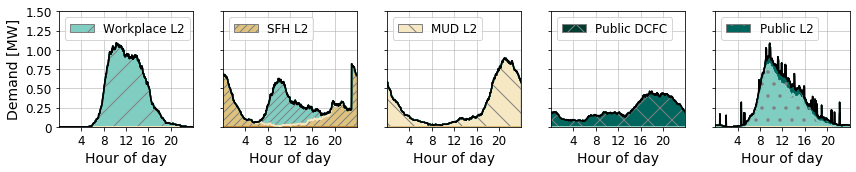

In [261]:
fig, axes = plt.subplots(1, 5, figsize=(12, 2.5), sharex=True, sharey=True)
legend_keys = ['Residential L2', 'MUD L2', 'Workplace L2', 'Public L2', 'Public DCFC']
legend_order  = {0:2, 1:0, 2:1, 3:4, 4:3}
for i, group_number in enumerate([72, 75, 85, 84, 71]):
#     print('---'*5)
    print(group_number)
    data = DataSetConfigurations(data_set='CP')
    speech = SPEECh(data=data, penetration_level=1.0, outside_california=True, states=['OR'])
    speech.pg = pd.DataFrame({'pg':(1/136)*np.ones((136, ))})
    config = SPEEChGeneralConfiguration(speech, remove_timers=False)
    config.change_pg(new_weights={group_number: 1})
    config.num_evs(1000)
    config.groups()
    config.run_all(verbose=False, weekday='weekday')
    config.run_all(verbose=False, weekday='weekday')
    yax = False
    if i == 0:
        yax = True
    if i == 4:
        axes[i] = plot_custom(axes[i], speech, config.total_load_segments, config.total_load_dict, yax=yax, save_str='../Plotting/fig_sample_clusters.pdf', legend_subset=[legend_keys[legend_order[i]]])
    else:
        axes[i] = plot_custom(axes[i], speech, config.total_load_segments, config.total_load_dict, yax=yax, legend_subset=[legend_keys[legend_order[i]]])#, save_str=save_str)

In [262]:
epairs = [(0., 600.), (600.,1000.), (1000., 1600.), (1600., 2000.), (2000., 3000.), (3000., 4000.), (4000., 6000.)]

In [266]:
summary_table = pd.DataFrame({'Energy Lower Bound':np.zeros((7, )), 'Energy Upper Bound':np.zeros((7, ))})
for i, epair in enumerate(epairs):
    tmp = driver_subset.loc[(driver_subset['Total Energy']>epair[0])&(driver_subset['Total Energy']<=epair[1])]
    tmp2 = tmp.loc[(tmp.loc[:, ['Num Single Family Residential Sessions', 'Num MUD Sessions']].sum(axis=1)==0)&(tmp['Num Workplace Sessions'] == 0)]
    inds = tmp2.loc[tmp2['Battery Capacity']<50].index
    summary_table.loc[i, 'SmallBatt NoHome_NoWork EnergyPerSession'] = np.mean(tmp2.loc[inds, 'Total Energy'].values / tmp2.loc[inds, 'Num Sessions'].values)
    inds = tmp2.loc[tmp2['Battery Capacity']>=50].index
    summary_table.loc[i, 'BigBatt NoHome_NoWork EnergyPerSession'] = np.mean(tmp2.loc[inds, 'Total Energy'].values / tmp2.loc[inds, 'Num Sessions'].values)

    tmp2 = tmp.loc[(tmp.loc[:, ['Num Single Family Residential Sessions', 'Num MUD Sessions']].sum(axis=1)==0)&(tmp['Num Workplace Sessions'] > 0)]
    inds = tmp2.loc[tmp2['Battery Capacity']<50].index
    summary_table.loc[i, 'SmallBatt NoHome_Work EnergyPerSession'] = np.mean(tmp2.loc[inds, 'Total Energy'].values / tmp2.loc[inds, 'Num Sessions'].values)
    inds = tmp2.loc[tmp2['Battery Capacity']>=50].index
    summary_table.loc[i, 'BigBatt NoHome_Work EnergyPerSession'] = np.mean(tmp2.loc[inds, 'Total Energy'].values / tmp2.loc[inds, 'Num Sessions'].values)
    
    tmp2 = tmp.loc[(tmp.loc[:, ['Num Single Family Residential Sessions', 'Num MUD Sessions']].sum(axis=1)>0)&(tmp['Num Workplace Sessions'] ==0)]
    inds = tmp2.loc[tmp2['Battery Capacity']<50].index
    summary_table.loc[i, 'SmallBatt Home_NoWork EnergyPerSession'] = np.mean(tmp2.loc[inds, 'Total Energy'].values / tmp2.loc[inds, 'Num Sessions'].values)
    inds = tmp2.loc[tmp2['Battery Capacity']>=50].index
    summary_table.loc[i, 'BigBatt Home_NoWork EnergyPerSession'] = np.mean(tmp2.loc[inds, 'Total Energy'].values / tmp2.loc[inds, 'Num Sessions'].values)

    tmp2 = tmp.loc[(tmp.loc[:, ['Num Single Family Residential Sessions', 'Num MUD Sessions']].sum(axis=1)>0)&(tmp['Num Workplace Sessions'] >0)]
    inds = tmp2.loc[tmp2['Battery Capacity']<50].index
    summary_table.loc[i, 'SmallBatt Home_Work EnergyPerSession'] = np.mean(tmp2.loc[inds, 'Total Energy'].values / tmp2.loc[inds, 'Num Sessions'].values)
    inds = tmp2.loc[tmp2['Battery Capacity']>=50].index
    summary_table.loc[i, 'BigBatt Home_Work EnergyPerSession'] = np.mean(tmp2.loc[inds, 'Total Energy'].values / tmp2.loc[inds, 'Num Sessions'].values)

    summary_table.loc[i, 'Energy Lower Bound'] = epair[0]
    summary_table.loc[i, 'Energy Upper Bound'] = epair[1]

In [269]:
summary_table.round(2)

,Energy Lower Bound,Energy Upper Bound,SmallBatt NoHome_NoWork EnergyPerSession,BigBatt NoHome_NoWork EnergyPerSession,SmallBatt NoHome_Work EnergyPerSession,BigBatt NoHome_Work EnergyPerSession,SmallBatt Home_NoWork EnergyPerSession,BigBatt Home_NoWork EnergyPerSession,SmallBatt Home_Work EnergyPerSession,BigBatt Home_Work EnergyPerSession
0,0.0,600.0,9.38,12.89,9.62,14.09,8.96,14.47,9.48,15.67
1,600.0,1000.0,11.28,20.42,10.83,19.28,10.72,19.93,10.04,16.65
2,1000.0,1600.0,12.28,24.91,11.42,21.09,10.76,24.62,10.24,21.92
3,1600.0,2000.0,12.52,24.71,11.89,21.60,11.40,22.56,11.47,20.72
4,2000.0,3000.0,13.41,26.71,12.98,22.04,10.71,25.10,11.30,22.41
5,3000.0,4000.0,14.65,26.17,15.25,22.24,12.13,24.22,12.50,23.83
6,4000.0,6000.0,16.37,28.46,16.38,24.07,12.26,25.38,12.88,23.00


In [270]:
summary_table.to_csv('../Plotting/table_energypersession.csv')